**Problem** Conversion between two channel of LED power to brightness and color temperature

---

On the electronic side of lamp control, we are using PWM to control the power of an array of cool-white LEDs and warm-white LEDs, to get a mixture of vary color temperature. The power of each LED, denoted as $P_c$ and $P_w$ respectively, can be controlled by our MCU. The target states are the overall brightness ($B$) and color temperature ($T$). We want to find a function/relationship between the output power of the two LEDs and the overall brightness and color temperature.

Let's further define:

- $P_c$, the power of the cool-white LED. $P_c \in [0, 1]$, where 1 is the maximum (100%) power
- Similarly, we have $P_w \in [0, 1]$
- $B$, the overall brightness. $B \in [0, 1]$, where
    - 0 is when both $P_c$ and $P_w$ is 0
    - 1 is when both $P_c$ and $P_w$ is 1
- $T$, the overall color temperature. $T \in [0, 1]$, where
    - 0 is 100% of cool-white and 0% of warm-white
    - 1 is 100% of warm-white and 0% of cool-white

In other words, we want to find the transformation from the $P_c-P_w$ space to the $B-T$ space. To make things easier, let's say $B$ and $T$ are independent of each other, we are hunting for a $f$ and $g$ such that

$$B=f(P_c, P_w)$$
$$T=g(P_c, P_w)$$



**Let's focus on the brightness `B` for the time being.** 

> A later discovery shows that the `cwww` (Cold White + Warm White) Light type from ESPHome [has an API]() to set temperature from `warm_white` and `cold_white` as percentage values directly, which means we don't have solve `T` function for now

Since my goal here is to find a reasonably good-enough transform for $B$, I will try to address this by looking at some special points first.

Some obvious points that are expected:

$P_c = 0$, $P_w = 0$ then $B = 0$

$P_c = 1$, $P_w = 0$ then $B = 1$

$P_c = 0$, $P_w = 1$ then $B = 1$

$P_c = 1$, $P_w = 1$ then $B = 1$


These are points $O(0,0,0)$, $A(0,1,1)$, $B(1,1,1)$ and $C(1,0,1)$ - green points on the drawing:


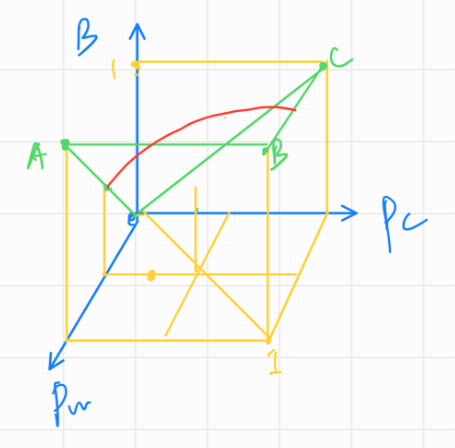



For using only these four points, we may naively have the linear transform function to be a combination of plane $OAB$ and $OBC$. However this doesn't accurate enough. Considering at such two points (red points on the drawing)

$U'(0.25, 0.5)$

$V'(0.5, 0.5)$

With such linear transform, we will have $f(0.25, 0.5) = f(0.5, 0.5)$. But in reality, when $P_w=0.5$, the overall brightness $B$ at $P_c=0.25$ should be darker than $B$ at $P_c=0.5$, i.e.

$$f(0.25, 0.5) < f(0.5, 0.5)$$

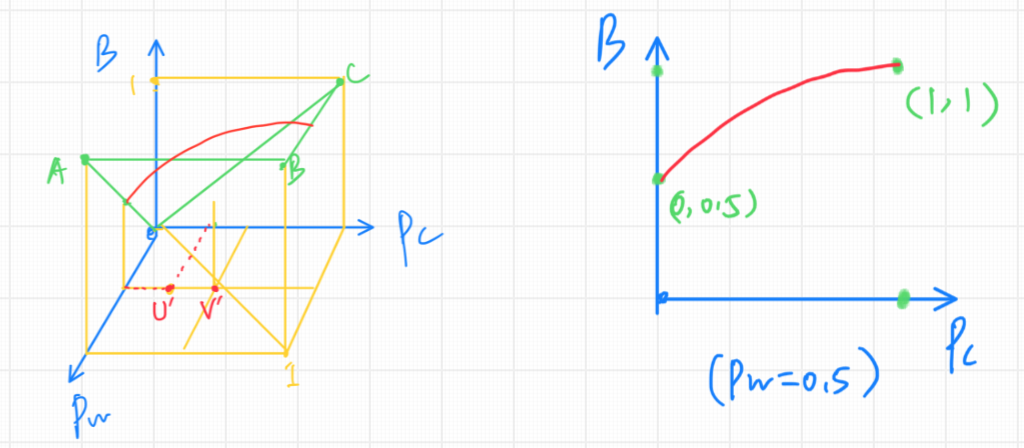

Eventually, we are more or less expecting a red curve line as shown, when $P_w=0.5$.

Similarily, we should also have such curved relation when $P_c=0.5$

We can try to fit a curve surface, using the above rough expectations, or contrains, i.e.

- Points $O$, $A$, $B$ and $C$
- Points on the curve when $P_w=0.5$
- Points on the curve when $P_c=0.5$



The following code implement the discussed idea:

- Generate points on line $OA$, $OC$, $AB$ and $BC$
    - _I don't actually care about the linearity when $P_c=0$, $P_w=0$, $P_c=1$, $P_w=1$. So I will assure they are linear. Thus straight lines (green lines)_
- Generate points on the two middle curves
- Fit a surface function with all the generated points. With some quick experiements, I find a simple quadratic surface works OK:

  $$z=A + Bx + Cy + Dx^2 + Ey^2 + Fxy$$

  ($z$ is $B$, $x$ is $P_c$, $y$ is $P_w$)

- Plot the fitting surface, and print the found parameters

In [1]:
import numpy as np
sample = 30

point3d_b_space = np.dtype([
    ('pc', np.float32),
    ('pw', np.float32),
    ('b', np.float32),
])

def func_ab(pc, pw):
    return np.ones_like(pc)

def func_bc(pc, pw):
    return np.ones_like(pw)

def func_oc(pc, pw):
    return pc

def func_oa(pc, pw):
    return pw

def func_mid_curve(x):
    return -0.5*(x**2) + x + 0.5

lin_01 = np.linspace(0, 1, num=sample)
ones = np.ones_like(lin_01)
zeros = np.zeros_like(lin_01)

def gen_xyz(z_func, x, y):
    return np.array([
        x, y, z_func(x, y)
    ])

AB = gen_xyz(func_ab, x=lin_01, y=ones)
BC = gen_xyz(func_bc, x=ones, y=lin_01)

OC = gen_xyz(func_oc, x=lin_01, y=zeros)
OA = gen_xyz(func_oa, x=zeros, y=lin_01)

mid_curve_pw = np.array([
    lin_01,
    ones * 0.5,
    func_mid_curve(lin_01)
])

mid_curve_pc = np.array([
    ones * 0.5,
    lin_01,
    func_mid_curve(lin_01)
])

In [2]:
# Flatten generated fitting points
x_data = []
y_data = []
z_data = []
for item in [AB, BC, OC, OA, mid_curve_pw, mid_curve_pc]:
    x_data.append(item[0])
    y_data.append(item[1])
    z_data.append(item[2])

x_data = np.concatenate(x_data)
y_data = np.concatenate(y_data)
z_data = np.concatenate(z_data)

print(f'Total of {len(x_data)} points generated')

Total of 180 points generated


<IPython.core.display.Javascript object>


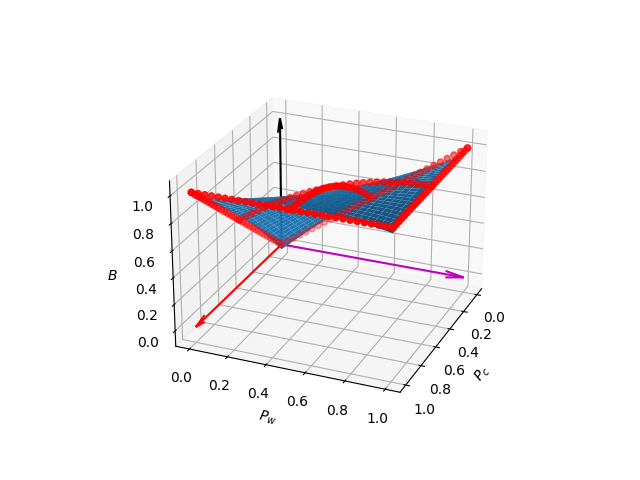

In [3]:
%matplotlib notebook

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def target_func(point_2d, a,b,c,d,e,f):
    """
    @param point_2d: The point in Pc-Pw space
    """
    pc, pw = point_2d[0], point_2d[1]
    x, y = pc, pw
    return a \
        + b*x + c*y \
        + d*(x**2) + e*(y**2) + f*x*y


# get fit parameters from scipy curve fit
parameters, covariance = curve_fit(target_func, [x_data, y_data], z_data)

# create surface function model
# create coordinate arrays for vectorized evaluations
X, Y = np.meshgrid(lin_01, lin_01)
# calculate Z coordinate array
Z = target_func(np.array([X, Y]), *parameters)

# setup figure object
ax = plt.figure().add_subplot(projection='3d')
# plot surface
ax.plot_surface(X, Y, Z)
# plot input data
ax.scatter(x_data, y_data, z_data, color='red')

# set plot descriptions
ax.set_xlabel('$P_c$')
ax.set_ylabel('$P_w$')
ax.set_zlabel('$B$')

# plotting arrow at terminal of the lines
aleng = 1
ax.quiver(0, 0, 0, aleng, 0, 0, length=1, arrow_length_ratio=0.1, color='r')
ax.quiver(0, 0, 0, 0, aleng, 0, length=1, arrow_length_ratio=0.1, color='m')
ax.quiver(0, 0, 0, 0, 0, aleng, length=1, arrow_length_ratio=0.1, color='k')

plt.show()

In [4]:
# The parameter values of our target_func
parameters

array([-0.03992806,  1.2732741 ,  1.2732741 , -0.2732741 , -0.2732741 ,
       -1.        ])

In [5]:
covariance

array([[ 3.16458805e-05, -6.39992223e-05, -6.39992206e-05,
         3.16754544e-05,  3.16754509e-05,  4.41455003e-05],
       [-6.39992223e-05,  2.94258512e-04,  7.39006037e-05,
        -2.29610975e-04, -2.97550945e-05, -8.82910084e-05],
       [-6.39992206e-05,  7.39006037e-05,  2.94258518e-04,
        -2.97551042e-05, -2.29610983e-04, -8.82909960e-05],
       [ 3.16754544e-05, -2.29610975e-04, -2.97551042e-05,
         2.29610976e-04,  2.97551012e-05,  2.35991010e-12],
       [ 3.16754509e-05, -2.97550945e-05, -2.29610983e-04,
         2.97551012e-05,  2.29610991e-04, -1.29092831e-11],
       [ 4.41455003e-05, -8.82910084e-05, -8.82909960e-05,
         2.35991022e-12, -1.29092822e-11,  1.76582012e-04]])

In [6]:
# from IPython.display import display, Markdown, Latex

# a,b,c,d,e,f = parameters

# display(Markdown('${}$'.format(
#     f'''b = {a}P_c'''
# )))